In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing, model_selection
import csv
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import random

### Data Preparation

In [4]:
def get_dataset(directory):
    data = pd.DataFrame(columns=['data', 'label'])
    for foldername in os.listdir(directory):
        folder = os.path.join(directory, foldername)
        if os.path.isdir(folder):
            files = os.listdir(folder)
            for filename in files:
                rel_path = os.path.join(directory, foldername, filename)
                temp_label = filename.split('.')[0].split('_')[0]
                if 'a' in temp_label:
                    label ='alcoholic'
                else:
                    label = 'control'

                temp_data = pd.DataFrame(columns=['data', 'label'], index=[0])

                rwb = np.load(rel_path)
                rwb.astype(np.float64).reshape(-1,1)
                # with open(rel_path, 'r') as file:
                    
                #     rwb = list(csv.reader(file, delimiter=","))[0]
                #     # scaler = preprocessing.MinMaxScaler()
                #     rwb = np.asarray(rwb).astype(np.float64).reshape(-1,1)
                #     # print(rwb)
                                
                temp_data['data'][0] = rwb
                temp_data['label'] = label
                
                # decomp = np.arange(0, 366)
                # plt.plot(decomp, df_data)
                # plt.xlabel('Dimension Number')
                # plt.ylabel('Wavelet Bispectrum Energy')
                # plt.show()
                data = pd.concat([data, temp_data], ignore_index=True)
    label_map = {"alcoholic": 1, "control": 0}
    data['label_map'] = data['label'].map(label_map)      
    return data

In [35]:
def get_batch(path):
    # loading extracted feature & label
    x = get_dataset(path)

    scaler = preprocessing.MinMaxScaler()

    series_list = [
        i for i in x["data"]
    ]

    # series_list = series_list.reshape(-1, 366, 1)

    labels_list = [i for i in x["label_map"]]
        
    # y = keras.utils.to_categorical(y[0])
    dataset = tf.data.Dataset.from_tensor_slices((series_list,labels_list))
    dataset = dataset.shuffle(len(labels_list)).batch(4)

    return dataset

In [37]:
test = get_batch('../smni_cmi_test_bispectrum_256')
for i in test:
    print(i)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

### Exploratory Data Analysis

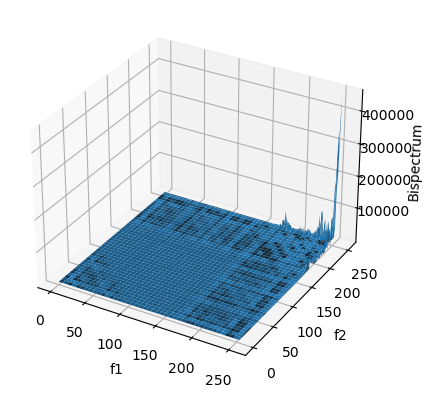

In [26]:
# Load the CSV file into a DataFrame
signal = np.load('../smni_cmi_test_bispectrum_256\co2a0000364\co2a0000364_30_bispectrum.npy')


# Plot the bispectrum using mesh plots
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(signal.shape[1]), np.arange(signal.shape[2]))
ax.plot_surface(X, Y, signal[0])
ax.set_xlabel('f1')
ax.set_ylabel('f2')
ax.set_zlabel('Bispectrum')
plt.show()


### Model Definition

In [27]:
def create_model():
    model = keras.models.Sequential()

    model.add(layers.Input(shape=(61, 255, 255,)))
    model.add(layers.Reshape((61, 255, 255, 1)))

    model.add(layers.Conv3D(filters=16, kernel_size=4, activation="relu"))
    model.add(layers.MaxPooling3D(pool_size=4))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv3D(filters=8, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling3D(pool_size=4))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation="relu"))

    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(256, activation="relu"))

    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation="sigmoid"))

    return model

### Define Callbacks

In [28]:
def myCallbacks(log_dir):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    return tensorboard_callback
    

### Main Program

In [32]:
lags = [256, 128, 64, 32, 16, 8, 4, 2]
folds = ['train_1', 'test_1', 'train_2', 'test_2']
epochs = 100
log_dir = 'logs'
train_dir = '../smni_cmi_train_bispectrum'
test_dir = '../smni_cmi_train_bispectrum'

recap = pd.DataFrame(index=lags, columns=folds)

In [36]:
for fold in range(1,3):
    for lag in [256]:
        if fold == 2:
            train_dir, test_dir = test_dir, train_dir
        
        train_temp_dir = train_dir + '_' + str(lag)
        test_temp_dir = test_dir + '_' + str(lag)

        train = get_batch('../smni_cmi_test_bispectrum_256')
        test_ds = get_batch('../smni_cmi_test_bispectrum_256')

        train_size = int(len(list(train.as_numpy_iterator()))*0.8)
        train_ds = train.take(train_size)
        val_ds = train.skip(train_size)

        log_path = os.path.join(log_dir, str(fold), str(lag))

        model = create_model()
        model.summary()

        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])

        history = model.fit(train_ds, epochs=epochs, validation_data=(val_ds), callbacks = myCallbacks(log_path))
        results = model.evaluate(test_ds, callbacks = myCallbacks(log_path))

        recap.loc[lag, 'train'+ '_' + str(fold)] = history.history['acc'][-1]
        recap.loc[lag, 'test'+ '_' + str(fold)] = results[1]

        model.save(os.path.join(log_path,'model.h5'))



InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [18]:
recap.to_csv('../Logs/Recap/recap.csv')

In [1]:
! tensorboard --logdir logs --port=8000

^C


In [37]:
! cd

c:\Users\fulky\OneDrive - UNIVERSITAS INDONESIA\Documents\Akademik\Final Year\Seminar\Code\notebook
